# Análise Exploratória de Dados Meteorológicos

Análise dos dados meteorológicos do estado de São Paulo processados pelo INMET.

## Objetivos:
1. Visualizar dados processados
2. Identificar padrões temporais
3. Analisar índices de conforto térmico
4. Detectar condições extremas

## 1. Importação dos Dados

Carregando o arquivo 'Data.xlsx' gerado pelo notebook ETL.ipynb, contendo dados diários agregados de ~47 estações meteorológicas do estado de SP (2000-presente).

In [1]:
import pandas as pd

df = pd.read_excel('Data.xlsx', 'Database')
df = df.reset_index()

## 2. Estações Meteorológicas

Verificando as estações disponíveis no dataset. Algumas podem ter valores ausentes (NaN) devido a manutenção ou instalação tardia dos equipamentos.

In [2]:
df['estacao'].unique()

array(['ARIRANHA', nan, 'AVARE', 'BARRA BONITA', 'BARRA DO TURVO',
       'BARRETOS', 'BARUERI', 'BAURU', 'BEBDOURO', 'BEBEDOURO',
       'BERTIOGA', 'BRAGANCA PAULISTA', 'CACHOEIRA PAULISTA',
       'CAMPOS DO JORDAO', 'CASA BRANCA', 'CRIOSFERA', 'DRACENA',
       'FRANCA', 'IBITINGA', 'IGUAPE', 'IPERO', 'ITAPEVA', 'ITAPIRA',
       'ITUVERAVA', 'JALES', 'JOSE BONIFACIO', 'LINS', 'MARILIA',
       'OURINHOS', 'PIRACICABA', 'PRADOPOLIS', 'PRESIDENTE PRUDENTE',
       'RANCHARIA', 'REGISTRO', 'SAO CARLOS', 'SAO LUIS DO PARAITINGA',
       'SAO LUIZ DO PARAITINGA', 'SAO MIGUEL ARCANJO',
       'SAO PAULO - INTERLAGOS', 'SAO PAULO - MIRANTE', 'SAO SEBASTIAO',
       'SAO SIMAO', 'SOROCABA', 'TAUBATE', 'TUPA', 'VALPARAISO',
       'VOTUPORANGA'], dtype=object)

## 4. Visualização das Séries Temporais

Análise visual de 4 variáveis principais:
- **Temperatura**: Variações diárias (média, máxima, mínima) com zona de conforto
- **Precipitação**: Quantidade diária de chuva
- **Umidade Relativa**: Porcentagem de umidade no ar
- **Radiação Solar**: Energia solar recebida

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Corrigir o fillna (método antigo está depreciado)
df['data'] = pd.to_datetime(df['data'])
df['estacao'] = df['estacao'].ffill()  # ou use: df['estacao'].fillna(method='ffill')

cities = sorted(df['estacao'].unique())

def update_plot(city):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    
    # Filtrar dados da cidade uma vez
    city_data = df[df['estacao'] == city]
    
    # Temperatura
    axs[0,0].plot(city_data['data'], city_data['temperatura_ar'], 'r-', label='Real', linewidth=1)
    axs[0,0].set_xlabel('Data', fontsize=12)
    axs[0,0].set_ylabel('Média de Temperatura (ºC)', fontsize=12)
    axs[0,0].set_title(f'Temperatura em {city}', fontsize=14)
    axs[0,0].grid(True, alpha=0.3)

    # Precipitação
    axs[0,1].plot(city_data['data'], city_data['precipitacao'], 'b-', label='Real', linewidth=1)
    axs[0,1].set_xlabel('Data', fontsize=12)
    axs[0,1].set_ylabel('Média de Precipitação (mm)', fontsize=12)
    axs[0,1].set_title(f'Precipitação em {city}', fontsize=14)
    axs[0,1].grid(True, alpha=0.3)

    # Radiação
    axs[1,0].plot(city_data['data'], city_data['radiacao'], 'r-', label='Real', linewidth=1)
    axs[1,0].set_xlabel('Data', fontsize=12)
    axs[1,0].set_ylabel('Média de Radiação (KJ/m²)', fontsize=12)
    axs[1,0].set_title(f'Radiação em {city}', fontsize=14)
    axs[1,0].grid(True, alpha=0.3)

    # Umidade
    axs[1,1].plot(city_data['data'], city_data['umidade_relativa'], 'b-', label='Real', linewidth=1)
    axs[1,1].set_xlabel('Data', fontsize=12)
    axs[1,1].set_ylabel('Média de Umidade Relativa', fontsize=12)
    axs[1,1].set_title(f'Umidade Relativa em {city}', fontsize=14)
    axs[1,1].grid(True, alpha=0.3)

    fig.suptitle("Análise Exploratória", fontsize=16)
    plt.tight_layout()
    plt.show()

# Criar o widget interativo corretamente
interactive_plot = widgets.interactive(update_plot, city=widgets.Dropdown(options=cities, description='Cidade:'))
display(interactive_plot)

interactive(children=(Dropdown(description='Cidade:', options=('ARIRANHA', 'AVARE', 'BARRA BONITA', 'BARRA DO …

## Análise de Tendência Linear com *LinearRegression* e Tendência Sazonal com *SARIMA*

## 6. Análise Sazonal

Comparação entre as quatro estações do ano:
- **Verão** (Dez-Fev): Mais quente e chuvoso
- **Outono** (Mar-Mai): Transição para clima seco
- **Inverno** (Jun-Ago): Mais frio e seco
- **Primavera** (Set-Nov): Aquecimento e aumento de chuvas

In [8]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import warnings

df['Year'] = df['data'].dt.year
df['Month'] = df['data'].dt.month

warnings.filterwarnings('ignore')

df_pred_1 = pd.DataFrame()

def prediction_1(df, city):
    df_ = df[df['estacao'] == city].copy()
    # df_ = df_city.groupby(['Year', 'Month']).agg({
    #     'temperatura_ar': 'mean',
    #     'precipitacao': 'sum',
    #     'radiacao': 'mean',
    #     'umidade_relativa': 'mean'
    # }).reset_index()
    # df_['data'] = pd.to_datetime(df_[['Year', 'Month']].assign(day=1))

    future_dates = pd.date_range(start=df_['data'].max() + pd.Timedelta(days=1), end=df_['data'].max() + pd.Timedelta(days=1) + pd.DateOffset(years=5), freq='D')
    future_df = pd.DataFrame({
        'Year': future_dates.year,
        'Month': future_dates.month,
        'data': future_dates
    })

    X = df_.copy().dropna()
    y_t = X['temperatura_ar'].copy()
    y_p = X['precipitacao'].copy()
    y_r = X['radiacao'].copy()
    y_u = X['umidade_relativa'].copy()

    X_numeric = np.arange(len(X)).reshape(-1, 1)
    
    # Temperatura
    lr_model_t = LinearRegression()
    lr_model_t.fit(X_numeric, y_t)
    model_t = SARIMAX(y_t, order=(1,1,1), seasonal_order=(0,1,1,12))
    result_t = model_t.fit(disp=False)
    rmse_t = np.sqrt(mean_squared_error(y_t, result_t.predict(start=0, end=len(y_t)-1)))
    coef_t = lr_model_t.coef_[0]
    rmse_t_LinReg = np.sqrt(mean_squared_error(y_t, lr_model_t.predict(X_numeric)))

    # Precipitação
    lr_model_p = LinearRegression()
    lr_model_p.fit(X_numeric, y_p)
    model_p = SARIMAX(y_p, order=(1,1,1), seasonal_order=(0,1,1,12))
    result_p = model_p.fit(disp=False)
    rmse_p = np.sqrt(mean_squared_error(y_p, result_p.predict(start=0, end=len(y_p)-1)))
    coef_p = lr_model_p.coef_[0]
    rmse_p_LinReg = np.sqrt(mean_squared_error(y_p, lr_model_p.predict(X_numeric)))

    # Radiação
    lr_model_r = LinearRegression()
    lr_model_r.fit(X_numeric, y_r)
    model_r = SARIMAX(y_r, order=(1,1,1), seasonal_order=(0,1,1,12))
    result_r = model_r.fit(disp=False)
    rmse_r = np.sqrt(mean_squared_error(y_r, result_r.predict(start=0, end=len(y_r)-1)))
    coef_r = lr_model_r.coef_[0]
    rmse_r_LinReg = np.sqrt(mean_squared_error(y_r, lr_model_r.predict(X_numeric)))

    # Umidade
    lr_model_u = LinearRegression()
    lr_model_u.fit(X_numeric, y_u)
    model_u = SARIMAX(y_u, order=(1,1,1), seasonal_order=(0,1,1,12))
    result_u = model_u.fit(disp=False)
    rmse_u = np.sqrt(mean_squared_error(y_u, result_u.predict(start=0, end=len(y_u)-1)))
    coef_u = lr_model_u.coef_[0]
    rmse_u_LinReg = np.sqrt(mean_squared_error(y_u, lr_model_u.predict(X_numeric)))

    df_ = pd.concat([df_.drop(columns=['temperatura_ar', 'precipitacao', 'radiacao', 'umidade_relativa']), future_df], axis=0)
    df_ = df_.reset_index(drop=True)

    X_numeric_full = np.arange(len(df_)).reshape(-1, 1)

    df_['temperatura_sarima'] = result_t.predict(start=0, end=len(df_)-1)
    df_['temperatura_linear'] = lr_model_t.predict(X_numeric_full)

    df_['precipitacao_sarima'] = result_p.predict(start=0, end=len(df_)-1)
    df_['precipitacao_linear'] = lr_model_p.predict(X_numeric_full)

    df_['radiacao_sarima'] = result_r.predict(start=0, end=len(df_)-1)
    df_['radiacao_linear'] = lr_model_r.predict(X_numeric_full)

    df_['umidade_sarima'] = result_u.predict(start=0, end=len(df_)-1)
    df_['umidade_linear'] = lr_model_u.predict(X_numeric_full)

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Temperatura
    axs[0,0].plot(X['data'], y_t, 'b-', label='Real', linewidth=2)
    axs[0,0].plot(df_['data'], df_['temperatura_sarima'], 'r-', label=f'SARIMAX: RMSE={rmse_t:.2f}', linewidth=0.5)
    axs[0,0].plot(df_['data'], df_['temperatura_linear'], 'g--', label=f'RegLin: Coeficiente angular = {coef_t:.4f}°C/mês | RMSE = {rmse_t_LinReg}', linewidth=0.5)
    axs[0,0].axvline(x=X['data'].iloc[-1], color='gray', linestyle=':', linewidth=1.5)
    axs[0,0].set_xlabel('Data', fontsize=12)
    axs[0,0].set_ylabel('Média de Temperatura (ºC)', fontsize=12)
    axs[0,0].set_title(f'Temperatura em {city}', fontsize=14)
    axs[0,0].legend(fontsize=9)
    axs[0,0].grid(True, alpha=0.3)

    # Precipitação
    axs[0,1].plot(X['data'], y_p, 'b-', label='Real', linewidth=2)
    axs[0,1].plot(df_['data'], df_['precipitacao_sarima'], 'r-', label=f'SARIMAX: RMSE={rmse_p:.2f}', linewidth=0.5)
    axs[0,1].plot(df_['data'], df_['precipitacao_linear'], 'g--', label=f'RegLin: Coeficiente angular = {coef_p:.4f}mm/mês | RMSE = {rmse_p_LinReg}', linewidth=0.5)
    axs[0,1].axvline(x=X['data'].iloc[-1], color='gray', linestyle=':', linewidth=1.5)
    axs[0,1].set_xlabel('Data', fontsize=12)
    axs[0,1].set_ylabel('Média de Precipitação (mm)', fontsize=12)
    axs[0,1].set_title(f'Precipitação em {city}', fontsize=14)
    axs[0,1].legend(fontsize=9)
    axs[0,1].grid(True, alpha=0.3)

    # Radiação
    axs[1,0].plot(X['data'], y_r, 'b-', label='Real', linewidth=2)
    axs[1,0].plot(df_['data'], df_['radiacao_sarima'], 'r-', label=f'SARIMAX: RMSE={rmse_r:.2f}', linewidth=0.5)
    axs[1,0].plot(df_['data'], df_['radiacao_linear'], 'g--', label=f'RegLin:  Coeficiente angular = {coef_r:.4f}/mês | RMSE = {rmse_r_LinReg}', linewidth=0.5)
    axs[1,0].axvline(x=X['data'].iloc[-1], color='gray', linestyle=':', linewidth=1.5)
    axs[1,0].set_xlabel('Data', fontsize=12)
    axs[1,0].set_ylabel('Média de Radiação (KJ/m²)', fontsize=12)
    axs[1,0].set_title(f'Radiação em {city}', fontsize=14)
    axs[1,0].legend(fontsize=9)
    axs[1,0].grid(True, alpha=0.3)

    # Umidade
    axs[1,1].plot(X['data'], y_u, 'b-', label='Real', linewidth=2)
    axs[1,1].plot(df_['data'], df_['umidade_sarima'], 'r-', label=f'SARIMAX: RMSE={rmse_u:.2f}', linewidth=0.5)
    axs[1,1].plot(df_['data'], df_['umidade_linear'], 'g--', label=f'RegLin:  Coeficiente angular = {coef_u:.4f}/mês | RMSE = {rmse_u_LinReg}', linewidth=0.5)
    axs[1,1].axvline(x=X['data'].iloc[-1], color='gray', linestyle=':', linewidth=1.5)
    axs[1,1].set_xlabel('Data', fontsize=12)
    axs[1,1].set_ylabel('Média de Umidade Relativa', fontsize=12)
    axs[1,1].set_title(f'Umidade Relativa em {city}', fontsize=14)
    axs[1,1].legend(fontsize=9)
    axs[1,1].grid(True, alpha=0.3)

    fig.suptitle("Previsão de Variáveis Meteorológicas - SARIMAX vs Regressão Linear", fontsize=14)
    plt.tight_layout()
    plt.show()

    global df_pred_1
    df_pred_1 = df_[['data', 'temperatura_sarima', 'temperatura_linear', 'precipitacao_sarima',
                      'precipitacao_linear',  'radiacao_sarima',  'radiacao_linear',  'umidade_sarima', 'umidade_linear']]

# Preparar dados
df['data'] = pd.to_datetime(df['data'])
df['estacao'] = df['estacao'].ffill()
cities = sorted(df['estacao'].unique())

# Criar widget interativo
interactive_prediction = widgets.interactive(
    prediction_1,
    df=widgets.fixed(df),
    city=widgets.Dropdown(options=cities, description='Cidade:', value='SAO PAULO - MIRANTE')
)

display(interactive_prediction)

interactive(children=(Dropdown(description='Cidade:', index=38, options=('ARIRANHA', 'AVARE', 'BARRA BONITA', …

In [ ]:
print(df_pred_1[df_pred_1['data']=='2020-01-01'])

           data  temperatura_sarima  temperatura_linear  precipitacao_sarima  \
4895 2020-01-01           26.669685           20.573199             8.864287   

      precipitacao_linear  radiacao_sarima  radiacao_linear  umidade_sarima  \
4895              4.49458      1477.106737      1321.243743       65.859619   

      umidade_linear  
4895       68.644668  


## Mapa de correlação de relação entre variáveis

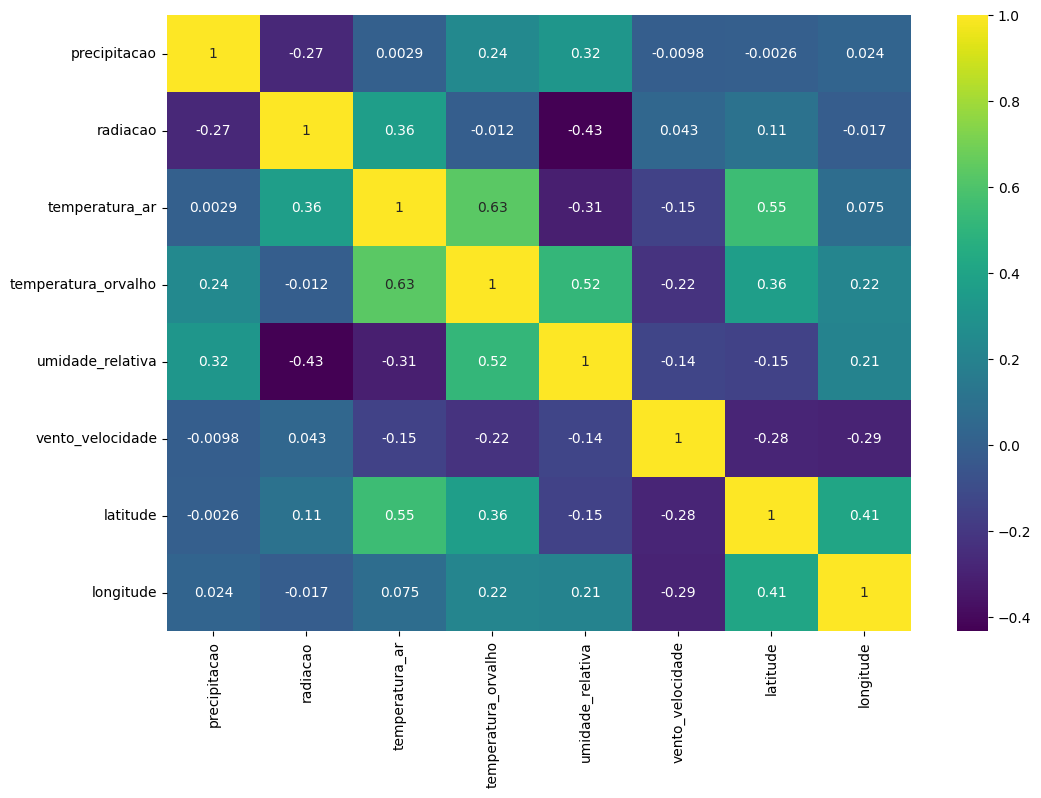

In [ ]:
numeric_data = df[['precipitacao', 'radiacao', 'temperatura_ar', 'temperatura_orvalho',
       'umidade_relativa', 'vento_velocidade', 'latitude', 'longitude']]

import seaborn as sns
import matplotlib.pyplot as plt 


plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='viridis')
plt.show()

## Aplicação do LSTM para previsão

In [5]:
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os
import ipywidgets as widgets
from IPython.display import display

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

WINDOW_SIZE = 60
TRAIN_SPLIT = 0.8
EPOCHS = 10
BATCH_SIZE = 32


# Converter coluna 'data' para datetime
df['data'] = pd.to_datetime(df['data'])

df['estacao'] = df['estacao'].ffill()
cities = sorted(df['estacao'].unique())

df_pred_2 = pd.DataFrame(columns=['data'])

def LSTM_prediction(city):
    for feature in ['temperatura_ar', 'precipitacao', 'umidade_relativa', 'radiacao']:
        # Remover NaN
        df_clean = df[df['estacao']==city]
        df_clean = df_clean[['data', f'{feature}']].dropna().reset_index(drop=True)

        # Extrair valores de temperatura
        temperature = df_clean[f'{feature}'].values.reshape(-1, 1)

        scaler = StandardScaler()
        temperature_scaled = scaler.fit_transform(temperature)

        split_index = int(len(temperature_scaled) * TRAIN_SPLIT)
        train_data = temperature_scaled[:split_index]
        test_data = temperature_scaled[split_index:]

        def create_sequences(data, window_size):
            X, y = [], []
            for i in range(window_size, len(data)):
                X.append(data[i-window_size:i, 0])
                y.append(data[i, 0])
            return np.array(X), np.array(y)

        X_train, y_train = create_sequences(train_data, WINDOW_SIZE)
        X_test, y_test = create_sequences(test_data, WINDOW_SIZE)

        # Reshape para LSTM [samples, timesteps, features]
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        model = keras.Sequential([
            keras.layers.LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, 1)),
            keras.layers.Dropout(0.2),
            keras.layers.LSTM(32),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(16, activation='relu'),
            keras.layers.Dense(1)
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae']
        )

        history = model.fit(
            X_train, y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.1,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    monitor='val_loss', 
                    patience=5, 
                    restore_best_weights=True
                ),
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss', 
                    factor=0.5, 
                    patience=3
                )
            ],
            verbose=1
        )

        # Predizer no conjunto de teste
        predictions_scaled = model.predict(X_test, verbose=0)
        predictions = scaler.inverse_transform(predictions_scaled)

        # Desnormalizar os valores reais de teste
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

        test_start_idx = split_index + WINDOW_SIZE
        test_end_idx = test_start_idx + len(predictions)

        result_df = df_clean.iloc[test_start_idx:test_end_idx].copy()
        result_df[f'{feature}_predita'] = predictions.flatten()

        mae = mean_absolute_error(y_test_actual, predictions)
        rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
        r2 = r2_score(y_test_actual, predictions)

        # Número de dias para prever
        future_days = 60

        # Última sequência conhecida
        last_sequence = temperature_scaled[-WINDOW_SIZE:].flatten()

        # Gerar previsões iterativas
        future_predictions_scaled = []
        current_sequence = last_sequence.copy()

        for _ in range(future_days):
            input_seq = current_sequence.reshape(1, WINDOW_SIZE, 1)
            next_pred = model.predict(input_seq, verbose=0)[0, 0]
            future_predictions_scaled.append(next_pred)
            current_sequence = np.append(current_sequence[1:], next_pred)

        # Desnormalizar previsões futuras
        future_predictions = scaler.inverse_transform(
            np.array(future_predictions_scaled).reshape(-1, 1)
        ).flatten()

        # Criar datas futuras
        last_date = df_clean['data'].iloc[-1]
        future_dates = pd.date_range(
            start=last_date + pd.Timedelta(days=1),
            periods=future_days,
            freq='D'
        )

        future_df = pd.DataFrame({
            'data': future_dates,
            f'{feature}_predita': future_predictions
        })
        
        plt.figure(figsize=(18, 6))

        # Dados de treino
        train_df = df_clean.iloc[:split_index]
        plt.plot(train_df['data'], train_df[f'{feature}'], 
                label='Treino', color='lightblue', alpha=0.6, linewidth=1)

        # Dados reais de teste
        plt.plot(result_df['data'], result_df[f'{feature}'], 
                label='Real (Teste)', color='blue', linewidth=2)

        # Predições
        plt.plot(result_df['data'], result_df[f'{feature}_predita'], 
                label='Predito', color='red', linestyle='--', linewidth=2)

        # Previsão futura (60 dias)
        plt.plot(future_df['data'], future_df[f'{feature}_predita'], 
                label='Previsão Futura (60 dias)', color='green', linestyle='-', 
                linewidth=2.5, marker='o', markersize=2)

        plt.title(f'Previsão de {feature} - {city} | MAE: {mae:.3f} | R²: {r2:.3f} | Projeção: 60 dias', 
                fontsize=14, fontweight='bold')
        plt.xlabel('Data', fontsize=12)
        plt.ylabel(f'{feature}', fontsize=12)
        plt.legend(loc='best', fontsize=10)
        plt.grid(True, alpha=0.3)

        import matplotlib.dates as mdates
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        plt.xticks(rotation=90, ha='right')

        plt.tight_layout()
        plt.show()
        global df_pred_2
        df_aux = pd.merge(result_df.reset_index(drop=True), future_df.reset_index(drop=True), on=['data', f'{feature}_predita'], how='outer')
        df_pred_2 = pd.merge(df_pred_2, df_aux, on=['data'], how='outer')
        print(df_pred_2)

# Widget interativo corrigido
interactive_prediction = widgets.interactive(
    LSTM_prediction,
    city=widgets.Dropdown(options=cities, description='Cidade:', value='SOROCABA')
)

display(interactive_prediction)

interactive(children=(Dropdown(description='Cidade:', index=41, options=('ARIRANHA', 'AVARE', 'BARRA BONITA', …

Resumo dos modelos aplicados para a cidade selecionada

In [9]:
df_pred = pd.merge(df_pred_1, df_pred_2, 'outer').reset_index(drop=True)
print(df_pred[df_pred['data']=='2025-11-25'])

           data  temperatura_sarima  temperatura_linear  precipitacao_sarima  \
7050 2025-11-25           17.388467           20.788841             4.648962   

      precipitacao_linear  radiacao_sarima  radiacao_linear  umidade_sarima  \
7050             4.526089      1370.703858      1392.696645       67.747511   

      umidade_linear  temperatura_ar  temperatura_ar_predita  precipitacao  \
7050       66.671345             NaN                     NaN           NaN   

      precipitacao_predita  umidade_relativa  umidade_relativa_predita  \
7050                   NaN               NaN                       NaN   

      radiacao  radiacao_predita  
7050       NaN               NaN  


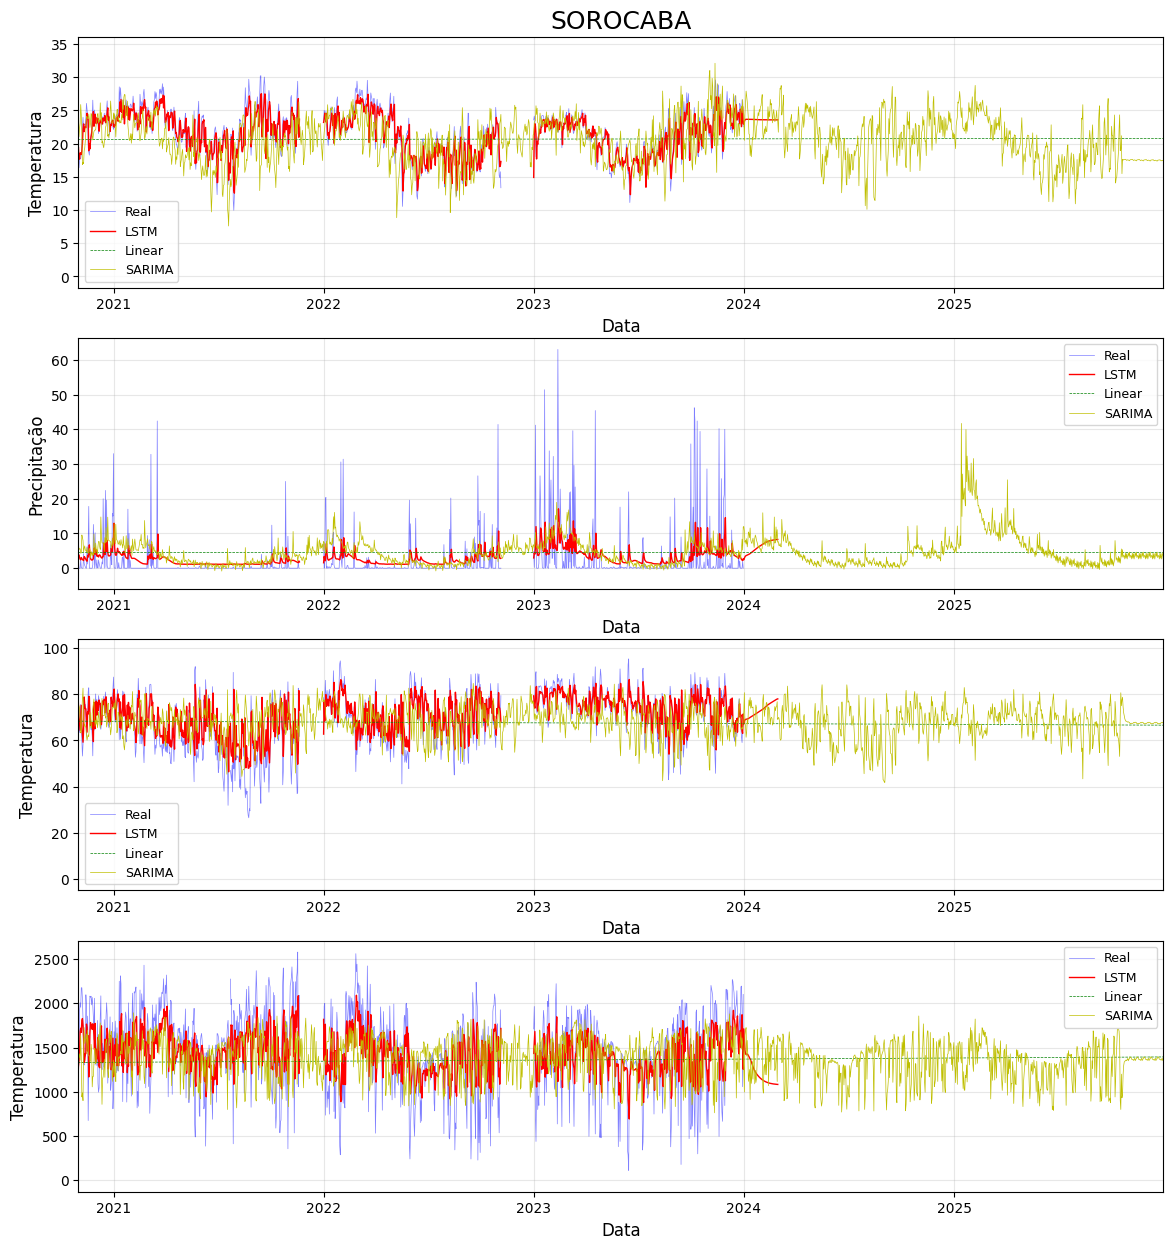

In [10]:
import matplotlib.pyplot as plt
import datetime as dt

fig, axs = plt.subplots(4, 1, figsize=(14, 15))

start = df['data'].max() - dt.timedelta(365*5)
end = df['data'].max() + dt.timedelta(60)

# fig.suptitle('SOROCABA', fontsize=18)

axs[0].plot(df_pred['data'], df_pred['temperatura_ar'], 'b-', label='Real', alpha=0.5, linewidth=0.5)
axs[0].plot(df_pred['data'], df_pred['temperatura_ar_predita'], 'r-', label='LSTM', linewidth=1)
axs[0].plot(df_pred['data'], df_pred['temperatura_linear'], 'g--', label='Linear', linewidth=0.5)
axs[0].plot(df_pred['data'], df_pred['temperatura_sarima'], 'y-', label='SARIMA', linewidth=0.5)
axs[0].set_xlabel('Data', fontsize=12)
axs[0].set_ylabel('Temperatura', fontsize=12)
axs[0].set_xlim(start, end)
axs[0].set_title('SOROCABA', fontsize=18)
axs[0].legend(fontsize=9)
axs[0].grid(True, alpha=0.3)
            
axs[1].plot(df_pred['data'], df_pred['precipitacao'], 'b-', label='Real', alpha=0.5, linewidth=0.5)
axs[1].plot(df_pred['data'], df_pred['precipitacao_predita'], 'r-', label='LSTM', linewidth=1)
axs[1].plot(df_pred['data'], df_pred['precipitacao_linear'], 'g--', label='Linear', linewidth=0.5)
axs[1].plot(df_pred['data'], df_pred['precipitacao_sarima'], 'y-', label='SARIMA', linewidth=0.5)
axs[1].set_xlabel('Data', fontsize=12)
axs[1].set_ylabel('Precipitação', fontsize=12)
axs[1].set_xlim(start, end)
axs[1].legend(fontsize=9)
axs[1].grid(True, alpha=0.3)

axs[2].plot(df_pred['data'], df_pred['umidade_relativa'], 'b-', label='Real', alpha=0.5, linewidth=0.5)
axs[2].plot(df_pred['data'], df_pred['umidade_relativa_predita'], 'r-', label='LSTM', linewidth=1)
axs[2].plot(df_pred['data'], df_pred['umidade_linear'], 'g--', label='Linear', linewidth=0.5)
axs[2].plot(df_pred['data'], df_pred['umidade_sarima'], 'y-', label='SARIMA', linewidth=0.5)
axs[2].set_xlabel('Data', fontsize=12)
axs[2].set_ylabel('Temperatura', fontsize=12)
axs[2].set_xlim(start, end)
axs[2].legend(fontsize=9)
axs[2].grid(True, alpha=0.3)

axs[3].plot(df_pred['data'], df_pred['radiacao'], 'b-', label='Real', alpha=0.5, linewidth=0.5)
axs[3].plot(df_pred['data'], df_pred['radiacao_predita'], 'r-', label='LSTM', linewidth=1)
axs[3].plot(df_pred['data'], df_pred['radiacao_linear'], 'g--', label='Linear', linewidth=0.5)
axs[3].plot(df_pred['data'], df_pred['radiacao_sarima'], 'y-', label='SARIMA', linewidth=0.5)
axs[3].set_xlabel('Data', fontsize=12)
axs[3].set_ylabel('Temperatura', fontsize=12)
axs[3].set_xlim(start, end)
axs[3].legend(fontsize=9)
axs[3].grid(True, alpha=0.3)



Análise das Métricas Metereologóicas 
1) Heat Index: https://en.wikipedia.org/wiki/Heat_index
2) WCI: https://en.wikipedia.org/wiki/Wind_chill
3) Humidex: https://en.wikipedia.org/wiki/Humidex

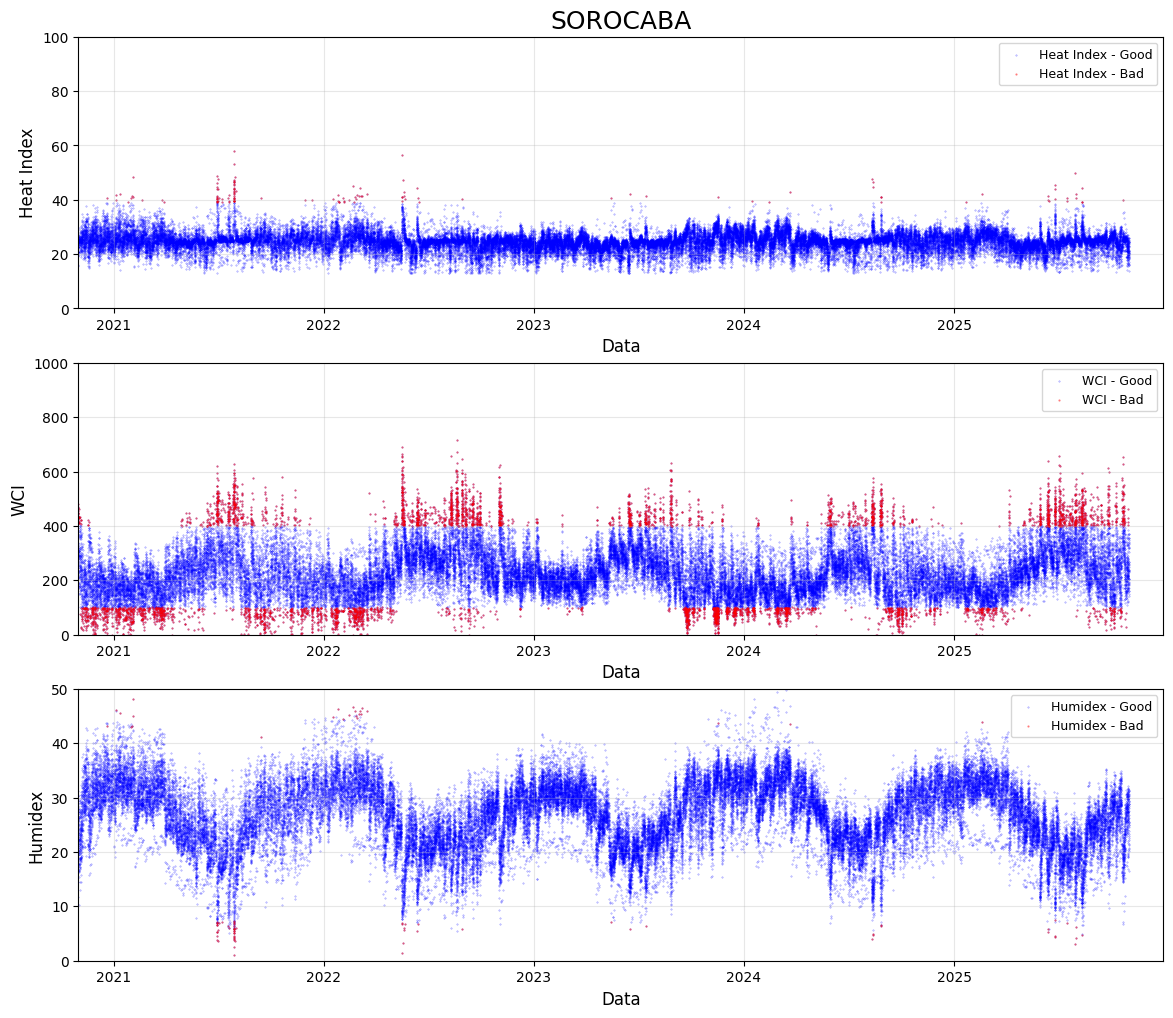

In [11]:
import matplotlib.pyplot as plt
import datetime as dt

fig, axs = plt.subplots(3, 1, figsize=(14, 12))

df_1 = df[df['Heat Index']>=39]
df_2 = df[(df['WCI']<100) | (df['WCI']>=400)]
df_3 = df[df['Heat Index']>=40]

start = df['data'].max() - dt.timedelta(365*5)
end = df['data'].max() + dt.timedelta(60)

axs[0].scatter(df['data'], df['Heat Index'], c='blue', s=0.1, alpha=0.5, label='Heat Index - Good')
axs[0].scatter(df_1['data'], df_1['Heat Index'], c='red', s=0.3, alpha=0.5, label='Heat Index - Bad')
axs[0].set_xlabel('Data', fontsize=12)
axs[0].set_ylabel('Heat Index', fontsize=12)
axs[0].set_title('SOROCABA', fontsize=18)
axs[0].set_xlim(start, end)
axs[0].set_ylim(0, 100)
axs[0].legend(fontsize=9)
axs[0].grid(True, alpha=0.3)
            
axs[1].scatter(df['data'], df['WCI'], c='blue', s=0.1, alpha=0.5, label='WCI - Good')
axs[1].scatter(df_2['data'], df_2['WCI'], c='red', s=0.3, alpha=0.5, label='WCI - Bad')
axs[1].set_xlabel('Data', fontsize=12)
axs[1].set_ylabel('WCI', fontsize=12)
axs[1].set_xlim(start, end)
axs[1].set_ylim(0, 1000)
axs[1].legend(fontsize=9)
axs[1].grid(True, alpha=0.3)

axs[2].scatter(df['data'], df['Humidex'], c='blue', s=0.1, alpha=0.5, label='Humidex - Good')
axs[2].scatter(df_3['data'], df_3['Humidex'], c='red', s=0.3, alpha=0.5, label='Humidex - Bad')
axs[2].set_xlabel('Data', fontsize=12)
axs[2].set_ylabel('Humidex', fontsize=12)
axs[2].set_xlim(start, end)
axs[2].set_ylim(0, 50)
axs[2].legend(fontsize=9)
axs[2].grid(True, alpha=0.3)



## 7. Conclusões

### Principais Descobertas:

✅ Dataset robusto com milhares de registros de 47 estações (2000-presente)

✅ Clara sazonalidade em todas as variáveis meteorológicas

✅ Eventos extremos de calor concentrados no verão

✅ Índices de conforto identificam períodos de risco à saúde

### Aplicações Práticas:

🏥 **Saúde Pública**: Alertas de ondas de calor

🌾 **Agricultura**: Planejamento de plantio e irrigação

🏗️ **Urbano**: Gestão de recursos hídricos e infraestrutura

⚡ **Energia**: Previsão de demanda (climatização)